In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import qutip
import theano
import theano.tensor as T
from collections import OrderedDict
import itertools
import os
import sys

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

import qubit_network as qn
from utils import *

pairs = list(itertools.combinations(range(4), 2))

# Test with interactions from [*Banchi et al.*](https://arxiv.org/abs/1509.04298).
The Fredkin gate is indeed reproduced with good fidelity, and regardless of the initial ancilla state.

In [3]:
net_paper = qn.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=('all', ['zz', 'xx', 'yy', 'z', 'x']),
    ancillae_state=qutip.basis(2, 0),
    target_gate=qutip.fredkin()
)
net_paper.J.set_value(np.zeros_like(net_paper.J.get_value()))

Jvalues = net_paper.J.get_value()

J01xx = 13.6
J02xx = J01xx
J12xx = -4.712
J12yy = J12zz = J12xx
J13xx = 8.4
J23xx = J13xx
J01zz = 11.15
J02zz = J01zz
h3x = 1.025
h0z = np.pi

Jvalues[net_paper.tuple_to_J_index(((0, 1), 'xx'))] = J01xx / 4
Jvalues[net_paper.tuple_to_J_index(((0, 2), 'xx'))] = J02xx / 4
Jvalues[net_paper.tuple_to_J_index(((1, 2), 'xx'))] = J12xx / 4
Jvalues[net_paper.tuple_to_J_index(((1, 2), 'yy'))] = J12yy / 4
Jvalues[net_paper.tuple_to_J_index(((1, 2), 'zz'))] = J12zz / 4
Jvalues[net_paper.tuple_to_J_index(((1, 3), 'xx'))] = J13xx / 4
Jvalues[net_paper.tuple_to_J_index(((2, 3), 'xx'))] = J23xx / 4
Jvalues[net_paper.tuple_to_J_index(((0, 1), 'zz'))] = J01zz / 4
Jvalues[net_paper.tuple_to_J_index(((0, 2), 'zz'))] = J02zz / 4
Jvalues[net_paper.tuple_to_J_index((0, 'z'))] = h0z / 2
Jvalues[net_paper.tuple_to_J_index((3, 'x'))] = h3x / 2

net_paper.J.set_value(Jvalues)

print('Fidelity: {}'.format(net_paper.test_fidelity(n_samples=1000)))

gate = qutip.Qobj(net_paper.get_current_gate(), dims=[[2, 2, 2, 2]] * 2)
gate = chop(gate).ptrace([0, 1, 2])
gate = gate * np.exp(-1j * np.angle(gate[0, 0]))
gate = gate / gate[0, 0]
chop(gate, 0.01)

Fidelity: 0.9999985454189124


Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.99999938  0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.99999938  0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.99999776  0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.99999641  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.99999911  0.        ]
 [ 0.          0.          0.          0.          0.          0.99999911
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.99999962]]

Using the same identical topology as per the paper, and the same set of initial interactions, the perfect fidelity is reproduced without problems (also, the net is saved into `data/nets/fredkin_Banchietal.pickle`):

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


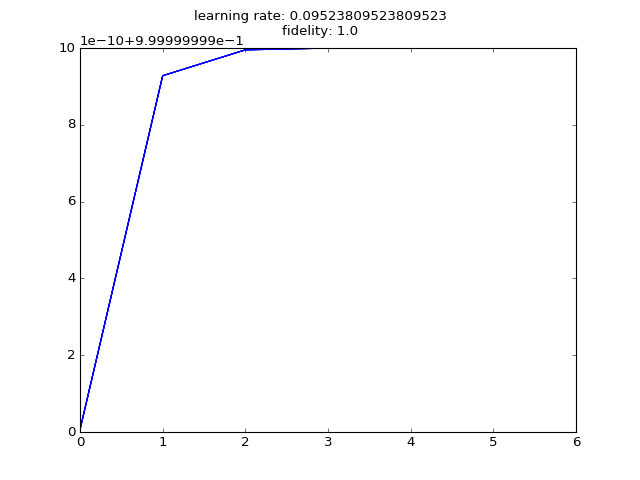

Finished training
Final fidelity: 0.999999999999999


In [4]:
# set up the same topology of Banchi et al.
net_topology = OrderedDict()
net_topology[((0, 1), 'xx')] = '1'
net_topology[((0, 2), 'xx')] = '1'
net_topology[((1, 2), 'xx')] = '2'
net_topology[((1, 2), 'yy')] = '2'
net_topology[((1, 2), 'zz')] = '2'
net_topology[((1, 3), 'xx')] = '3'
net_topology[((2, 3), 'xx')] = '3'
net_topology[((0, 1), 'zz')] = '4'
net_topology[((0, 2), 'zz')] = '4'
net_topology[(3, 'x')] = '5'
net_topology[(0, 'z')] = '6'

# define the network
net = qn.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    ancillae_state=qutip.basis(2, 0),
    net_topology=net_topology,
    target_gate=qutip.fredkin()
)
# insert the values given in the paper
net.J.set_value(np.array([13.6 / 4, -4.712 / 4, 8.4 / 4, 11.15 / 4, 1.025 / 2, 3.141 / 2]))

# train the network
qn.sgd_optimization(
    net=net,
    learning_rate=.1,
    n_epochs=10,
    batch_size=2,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

In [14]:
net = qn.load_network_from_file('../data/nets/fredkin_Banchietal.pickle')
net.test_fidelity_without_theano()[0, 0]

(0.99999999886732893+0j)

Load the above net from file, and analyze the corresponding matrix.

Tracing over the ancilla, multiplying the whole matrix with a global phase, and chopping away the small matrix elements, we get a perfect Fredkin over the system qubits.
Moreover, the unitary obtained is a tensor product of a unitary over the system qubits (a Fredkin gate), and a unitary over the ancilla qubit:
$$ \mathcal U_{} = \mathcal U_{fredkin} \otimes \mathcal V.$$
We can test this in a few ways:
1. Calling $\rho_{out}$ the density matrix after partial tracing the ancilla, we check that $\operatorname{Tr}(\rho_{out}^2) = 1$, that is, that the resulting state is pure.
2. Now that we know that $\mathcal U$ is a tensor product, we can trace over the ancilla to gate (up to a constant factor), the Fredkin gate.
3. Knowing that the associated fidelity is 1, and hence that the gate acting over the system is a Fredkin gate, we can obtain the gate acting on the ancilla by tracing $\mathcal U$ over the system, and dividing the result by the trace of the Fredkin gate (that is, 6).

Point **(1)** is necessarily verified if the fidelity is 1.
Let us see points **(2)** and **(3)** in action:

In [25]:
qn.trace_ancillae_and_normalize(net)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.74304268  0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          1.74304268  0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          1.74304268  0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          1.74304267  0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          1.74304268  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.74304268  0.        ]
 [ 0.          0.          0.          0.          0.          1.74304268
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.74304267]]

In [19]:
gate_ancilla = net.get_current_gate().ptrace([3]) / 6
qn.normalize_phase(gate)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.87152134+0.j          0.00000000-0.49035758j]
 [ 0.00000000-0.49035758j  0.87152134+0.j        ]]

# Reproduce the same parameters and gate, using the same topology but not knowing the correct parameters:

If we start with random initial parameters, with only `xx`, `yy`, `zz`, and the two self-interaction used in the paper, we don't get very far:

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


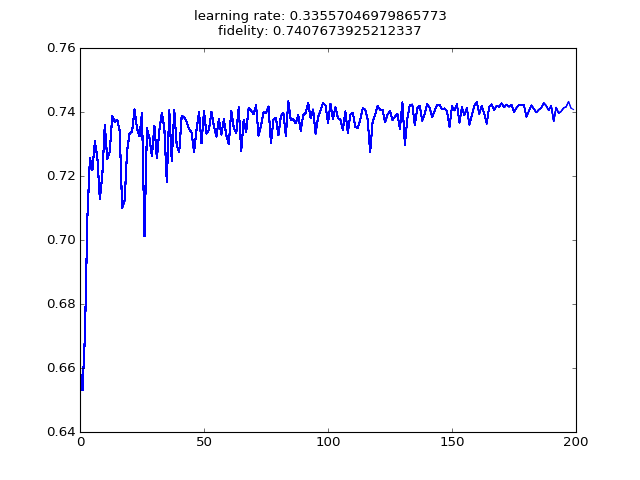

Finished training
Final fidelity: 0.7304610421775868


In [21]:
# set up a set of interaction mimicking those of Banchi et al.
interactions = []
for pair in pairs:
    interactions.append((pair, 'xx'))
    interactions.append((pair, 'yy'))
    interactions.append((pair, 'zz'))

interactions.append((0, 'z'))
interactions.append((3, 'x'))

# define the network
net = qn.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=interactions,
    ancillae_state=qutip.basis(2, 0)
)
net.J.set_value(np.ones_like(net.J.get_value()))

# train the network
qn.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=200,
    batch_size=10,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

Same thing if we use the same topology as per the paper, including the constraints on the various parameters:

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


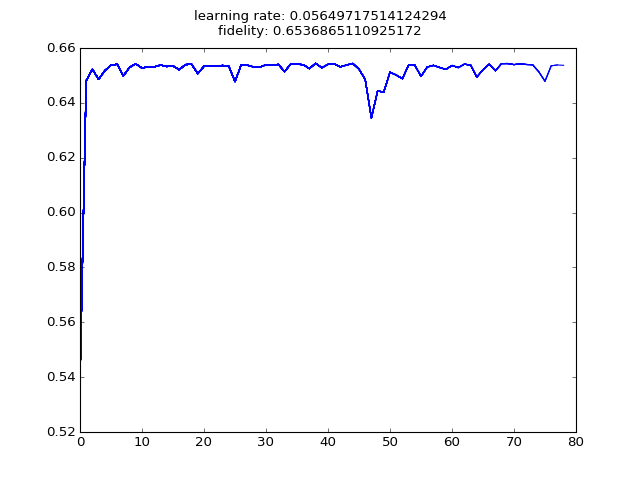

Finished training
Final fidelity: 0.6036661701260336


In [25]:
# set up a set of interaction mimicking those of Banchi et al.
net_topology = OrderedDict()
net_topology[((0, 1), 'xx')] = '1'
net_topology[((0, 2), 'xx')] = '1'
net_topology[((1, 2), 'xx')] = '2'
net_topology[((1, 2), 'yy')] = '2'
net_topology[((1, 2), 'zz')] = '2'
net_topology[((1, 3), 'xx')] = '3'
net_topology[((2, 3), 'xx')] = '3'
net_topology[((0, 1), 'zz')] = '4'
net_topology[((0, 2), 'zz')] = '4'
net_topology[(3, 'x')] = '5'
net_topology[(0, 'z')] = '6'

# define the network
net = qn.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    ancillae_state=qutip.basis(2, 0),
    net_topology=net_topology,
    target_gate=qutip.fredkin()
)
# net.J.set_value(np.array([13.6 / 4, -4.712 / 4, 8.4 / 4, 11.15 / 4, 1.025 / 2, 3.141 / 2]))

# train the network
qn.sgd_optimization(
    net=net,
    learning_rate=.1,
    n_epochs=200,
    batch_size=10,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

#### *However*, setting the initial values of every interaction parameter to `10`, still with the same topology as per the paper, the network converges *extremely quickly* to fidelity 1.

#### The resulting interactions are different than those in the paper, but they produce the same unitary evolution over the all qubit network:

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


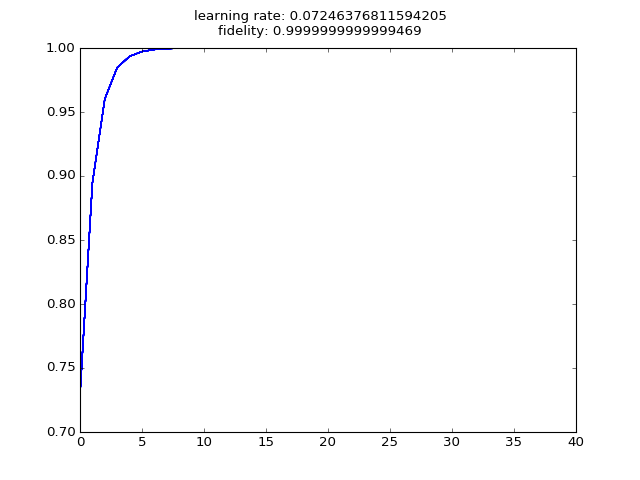

Finished training
Final fidelity: 0.9999999999999274


In [27]:
# define the network
net = qn.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    ancillae_state=qutip.basis(2, 0),
    net_topology=net_topology,
    target_gate=qutip.fredkin()
)
net.J.set_value(np.array([10., 10., 10., 10., 10., 10.]))
# net.J.set_value(np.array([13.6 / 4, -4.712 / 4, 8.4 / 4, 11.15 / 4, 1.025 / 2, 3.141 / 2]))

# train the network
qn.sgd_optimization(
    net=net,
    learning_rate=.1,
    n_epochs=40,
    batch_size=10,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01,
    saveafter_file='../data/nets/fredkin_3q+1a_paperTopology_1fid.pickle'
)

The interactions *look* very different than those in the paper:

In [36]:
outdict = net.get_interactions_with_Js(renormalize_parameters=True)
print_OrderedDict(outdict)

{
    "(((0, 1), 'xx'), ((0, 2), 'xx'))": 38.95448261505736,
    "(((1, 2), 'xx'), ((1, 2), 'yy'), ((1, 2), 'zz'))": 39.26990817184952,
    "(((1, 3), 'xx'), ((2, 3), 'xx'))": 36.62955921252687,
    "(((0, 1), 'zz'), ((0, 2), 'zz'))": 42.93821433320934,
    "((3, 'x'),)": 19.999921102204446,
    "((0, 'z'),)": 21.991147620075512
}


***However***, they produce basically the same evolution, with the difference of the unitary acting on the ancilla being different:

In [51]:
gate_paper = chop(qn.load_network_from_file('../data/nets/fredkin_Banchietal.pickle').get_current_gate())
gate_new = chop(qn.load_network_from_file('../data/nets/fredkin_3q+1a_paperTopology_1fid.pickle').get_current_gate())

gate1 = qn.trace_ancillae_and_normalize(gate_paper, 3)
gate2 = qn.trace_ancillae_and_normalize(gate_new, 3)

display(gate1)
display(gate2)

display(qn.normalize_phase(gate_paper.ptrace([3]) / 6))
display(qn.normalize_phase(gate_new.ptrace([3]) / 6))

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.74304268  0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          1.74304268  0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          1.74304268  0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          1.74304267  0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          1.74304268  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.74304268  0.        ]
 [ 0.          0.          0.          0.          0.          1.74304268
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.74304267]]

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.67818598  0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          1.67818598  0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          1.67818598  0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          1.67818598  0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          1.67818598  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.67818598  0.        ]
 [ 0.          0.          0.          0.          0.          1.67818598
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.67818598]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.87152134+0.j          0.00000000-0.49035758j]
 [ 0.00000000-0.49035758j  0.87152134+0.j        ]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.83909299+0.j          0.00000000-0.54398801j]
 [ 0.00000000-0.54398801j  0.83909299+0.j        ]]